# Getting started tutorial

## 1. Import of Python packages

A Python package is Python code written by someone else that can be imported into Python so you get access to it. Other words used for packages are modules or libraries. 
A package that contains many functions we need for scientific calculations is named `numpy`.
For example to import the function for calculating square roots we can write:

```python
from numpy import sqrt
print(sqrt(4))
```

To import all function within a package you can use the symbol "`*`", instead of using the name of the
function we want:

```python
from numpy import*
```

Note that, a Python package it self can consist of several other packages. For example we can import from the analysis package `exana` only the statistics package:


```python
from exana.statistics import* 
```

However, this way of importing packages is risky, because we can run into name clashes. This
is the case if for instance two functions in different packages have the same name. 
It therefore recommended to either (1) import only what you need, as we did in the first example, or (2) import packages explicitly with an "alias". For example we can import the `numpy` package with the alias `np`:


```python
import numpy as np
print(np.sqrt(4))
```
Now, all functions in `numpy` are available by writing `np.<name_of_function>`. 

---
**NOTE**

To see the list of functions available you can write `np.` (after that package is imported) and then press <kbd>tab</kbd>.

---

The most common native Python packages we use are:

In [1]:
import numpy as np                 # mathmatical functions
import matplotlib.pyplot as plt    # plotting
import quantities as pq            # units (sec, meter, etc.)

---
**NOTE**

By adding `plt.style.use('seaborn')`, i.e. using seaborn as theme in matplotlib, you get prettier plots:


In [2]:
plt.style.use('seaborn')

## 2. Notebook magic

You may sometimes see these lines at the top of notebooks:

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

The first two lines make sure that the packages you use in the current notebook is automatically reloaded if they are changed outside Jupyter.

The last line makes sure that plots are interactive and shown in the notebook.

## 3. Projects and actions

### 3.1 Reading project:
In expipe every project has one or multiple actions. An action is usually an axona session. 
To get a project you can type:

In [6]:
import pathlib
import expipe
project_path = pathlib.Path(r'C:\apps\pilot_exp') 
project = expipe.get_project(project_path)
project

type: project database_version: 2 project: pilot_exp

None

To see a list of actions in the project you can type `project.actions.keys()`. This will show you all actions in the project specified by an "action-id":

In [9]:
for key in project.actions.keys():
    print(key)

1009-281018-2
1778-270418-6


In [10]:
actions = project.actions
actions

### 3.2 Reading an action:

A specific action can be required by using the action-id:  `project.actions[<action-id>]`:

In [31]:
action = actions["1778-270418-6"] # axona_action

From the this action object you can then get the `exdir` file where the corresponding data is stored:

In [18]:
import exdir
import exdir.plugins.quantities

exdir_path = pathlib.Path(project_path) / "actions" / action.id / "data" / "main.exdir"
exdir_file = exdir.File(data_path, plugins=[exdir.plugins.quantities])

To see all folders in the `exdir` file you can write:

In [19]:
for name in exdir_file:
    print(name)

acquisition
epochs
general
processing
stimulus


## 4. Reading data in Neo

To analyze the data we need to read data in Neo which is  a package for representing electrophysiology data in Python.

In [21]:
from neo.io.exdirio import ExdirIO
io = ExdirIO(str(exdir_path))
block = io.read_block()
segment = block.segments[0]

### 4.1 Get epochs

__important__ The code below assumes that you have created visual stimulus epoch. For axona data, it can be done by running `generate_stim_group_and_epoch(action)` in `axona_helper.py`


From the `segment` object we can retrieve all experimental data. For example we can get stimulus times, values (orientation), and duration by reading the stimulus epoch:

In [26]:
from visualstimulation.analysis import *
from visualstimulation.helper import *
from visualstimulation.utils import *
from visualstimulation.axona_helper import *

stim_epoch = get_epoch(segment.epochs, "visual_stimulus")

print("orients:", stim_epoch.labels)
print("times:", stim_epoch.times)
print("durations:", stim_epoch.durations)

orients: [315. 180.  90. 135. 270.   0.  45. 225. 225.  90. 315.  45. 270.   0.
 135. 180. 135. 315.   0. 270. 225.  45. 180.  90.   0. 135. 315.  45.
  90. 270. 180. 225.  90. 180. 315. 135. 225.   0.  45. 270.   0. 180.
 135. 270. 315. 225.  90.  45. 315.  45. 180.   0. 225.  90. 270. 135.
 315.  90.   0. 225. 270. 135.  45. 180. 180. 225.  45. 315. 270.  90.
 135.   0.  90. 180.   0. 135. 270.  45. 315. 225.  90.   0. 225. 315.
 270.  45. 180. 135.  90.  45. 180. 225. 315. 270. 135.   0.] deg
times: [  3.753   5.009   6.373   7.784   9.146  10.559  11.897  13.317  14.68
  16.093  17.398  18.745  20.113  21.515  22.888  24.3    25.663  27.075
  28.438  29.85   31.213  32.626  33.989  35.381  36.741  38.141  39.505
  40.916  42.279  43.689  45.054  46.468  47.829  49.242  50.604  51.934
  53.296  54.699  56.071  57.483  58.846  60.249  61.621  63.032  64.397
  65.808  67.172  68.583  69.948  71.358  72.713  74.116  75.479  76.798
  78.17   79.583  80.946  82.358  83.695  85.1    86.46

### 4.2 Create trials
Next we can create trials based on stimulus. We loop through all units with 'cluster_group' annotation 'good' 
and store them in a dictionary.  Each unit in this dict consist of 
a list of trials (list of Neo spike trians) with respect to stimulus timestamps. 

In [27]:
stim_trials = make_stimulus_trials(block.channel_indexes, stim_epoch)

--- 
**NOTE**

To get trials directly from an action you can use `get_stim_trials()` function from the `visualstimulation.analysis` module:

In [28]:
stim_trials = get_stim_trials(action)

---

Now we can loop over each channel and their units:

In [29]:
for chx_id, chx in stim_trials.items():
    print("channel name:", chx_id)
    for un_id, trials in chx.items():
        print("unit:", un_id)  

channel name: Channel group 0
unit: 0
unit: 1
unit: 2
unit: 3
channel name: Channel group 2
unit: 0
unit: 1
unit: 2


### 4.2 Create trials based on orientation

We can sort the the trials above with respect to stimulus orientation:

<IPython.core.display.Javascript object>


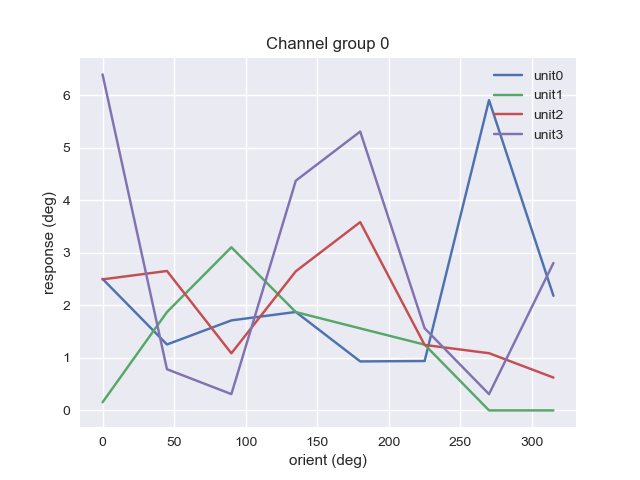

C:\Users\malinbro\AppData\Local\Continuum\anaconda3\lib\site-packages\elephant\spade.py:82: UserWarning: fim.so not found in elephant/spade_src folder,you are using the python implementation of fast fca
  'you are using the python implementation of fast fca')


<IPython.core.display.Javascript object>


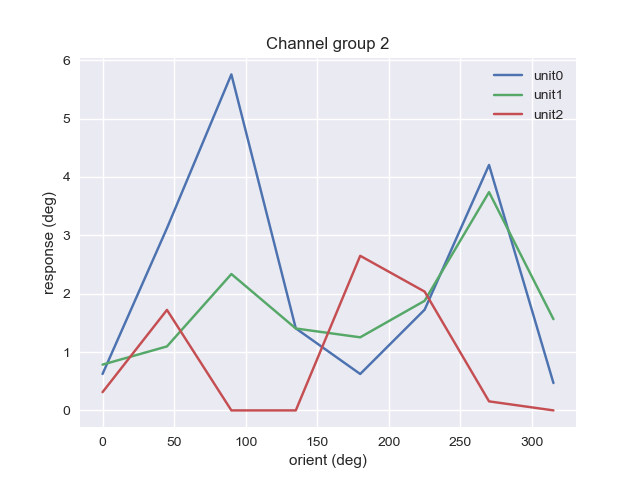

In [30]:
for chx_id, chx in stim_trials.items():
    plt.figure()
    for un_id, trials in chx.items():

        orients_trials = make_orientation_trials(trials)             # create orienatation trials    
        rates, orients = compute_orientation_tuning(orients_trials)  # compute orient tuning
        
        plt.plot(orients, rates, label="unit"+str(un_id))
        plt.xlabel("orient (deg)")
        plt.ylabel("response (deg)")
        plt.title(str(chx_id))
    plt.legend()
